# Importing

In [1]:
import csv
import pandas as pd
import numpy as np
import random as rd
import math
import os
import warnings
warnings.simplefilter(action='ignore')
from pathlib import Path
import collections
import sys
import copy
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm
from datetime import datetime, timedelta, date
from sklearn.preprocessing import PolynomialFeatures as pf
from tqdm import tqdm

# Environment
- 4 Types of features
    - Demand : user-defined range / continuous / # of demand of the product
    - inventory : no limiations / continuous / # of remaining product in inventory
    - defeat : [0, 1] / about 10 ~ 100 cases / % of defeat of certain machine
    - check : 0 or 1 / binary / if the defeat of machine is over certain %, it should be checked
- with polynomial linear regression

In [2]:
class CustomMachine : 
    def __init__(self, machine_params) : 
        self.machine_params = machine_params
        self.defeat_prop = machine_params['defeat_prop']
        self.checking = 0
        self.made_list, self.defeat_list = [], []
        
    def make(self, num) : 
        made = round(num * (1 - self.defeat_prop))        
        return made
    
"""
1. initialize : set machine, get demend
2. do action 
3. make product : update made, update machine params
4. get reward 
5. update inventory 
6. update demand 
7. update state
"""    
class CustomManufacturingProcess : 
    def __init__(self, process_params, machine_params) : 
        self.process_params, self.machine_params = process_params, machine_params
        
        self.demand, self.not_satisfied, self.inventory, self.made, self.day = self.get_demand(init = True), 0, 0, 0, 1
        self.demand_list, self.not_satisfied_list, self.inventory_list, self.made_list = [], [], [], []
        
        self.machines_list = [CustomMachine(machine_params[k]) for k in list(machine_params.keys())]
        self.state = {'demand' : self.demand, 'inventory' : self.inventory}
    
    def get_demand(self, init = False) :
        if init == True : 
            demand = self.process_params['demand_mu']
        else : 
            demand = np.random.normal(self.process_params['demand_mu'], self.process_params['demand_sigma'])
            if demand < self.process_params['demand_space'][0] : demand = self.process_params['demand_space'][0]
            elif demand > self.process_params['demand_space'][-1] : demand = self.process_params['demand_space'][-1]
        return round(demand)
    
    def make_product(self, action, save = True) : 
        under = 1/np.sum([1/machine.defeat_prop for machine in self.machines_list])
        current_made = [round(machine.make((1/machine.defeat_prop)* (action/under))) for machine in self.machines_list]
        self.made = int(np.sum(current_made))
            
    def get_reward(self, action) : 
        self.make_product(action)
        self.not_satisfied = np.max([self.demand - self.made - self.inventory, 0])
        self.not_satisfied_list.append(self.not_satisfied)
        self.inventory = np.max([0, self.inventory + self.made - self.demand])        
        if self.inventory > self.process_params['inventory_space'][-1] : self.inventory = self.process_params['inventory_space'][-1]
        self.state['inventory'] = self.inventory
        self.inventory_list.append(self.inventory)
        if self.day == self.process_params['max_day'] : 
            #return self.process_params['inventory_space'][-1] - self.inventory - self.not_satisfied * self.process_params['not_satisfied'], True
            return self.process_params['inventory_space'][-1] - np.mean(self.inventory_list) - self.not_satisfied * self.process_params['not_satisfied'], True
        else : 
            #return self.process_params['inventory_space'][-1] - self.inventory - self.not_satisfied * self.process_params['not_satisfied'], False 
            return self.process_params['inventory_space'][-1] - np.mean(self.inventory_list) - self.not_satisfied * self.process_params['not_satisfied'], False 
        
    def make_state(self) : 
        self.demand = self.get_demand() # demand update
        self.demand_list.append(self.demand)
        self.state['demand'] = self.demand + self.not_satisfied
        
        return self.state

## Parameters

In [3]:
max_epoch = 30000
#max_epoch/10
policy_params = {'alpha' : 1e-3, 'gamma' : 0.9, 'epsilon' : 0.8,
                 'max_epoch' : max_epoch, 
                 #'verbose' : max_epoch/10}
                 'verbose' : None}
process_params = {'action_space' : [0, 50], 
                  'inventory_space' : [0, 100],
                  'demand_space' : [10, 70], 'demand_mu' : 30, 'demand_sigma' : 5,
                  'sell_price' : 10, 'make_cost' : 5, 'inventory_cost' : 1, 'not_satisfied' : 10, 'max_day' : 20}
machine_params = {1 : {'defeat_prop' : 0.01}, 2 : {'defeat_prop' : 0.03}}
environment = CustomManufacturingProcess

## SARSA

#### Custom Class

In [4]:
class CustomSARSA : 
    def __init__(self, policy_params, process_params, machine_params, environment) : 
        self.policy_params, self.process_params, self.machine_params, self.environment = policy_params, process_params, machine_params, environment
        self.reward_list, self.action_list, self.demand_list, self.not_list, self.inventory_list = [], [], [], [], []
        
        self.environment = environment
        self.env = self.environment(self.process_params, self.machine_params) 
        
        self.gamma, self.alpha, self.epsilon = self.policy_params['gamma'], self.policy_params['alpha'], self.policy_params['epsilon']
        self.R_ba, self.q = 0, np.zeros((self.process_params['demand_space'][-1] * self.process_params['demand_space'][-1] + 1, 
                                         self.process_params['inventory_space'][-1] + 1, 
                                         self.process_params['max_day'] + 1,
                                         self.process_params['action_space'][-1] + 1))
    
    def state_action_loc(self, S, A) : 
        return S['demand'], S['inventory'], A
        
    def state_value(self, S, A, optim = False) :
        demand_loc, inventory_loc, action_loc = self.state_action_loc(S, A)
        if optim : q = self.q[(demand_loc, inventory_loc, self.env.day + 1, action_loc)]
        else : q = self.q[(demand_loc, inventory_loc, self.env.day, action_loc)]
        return q
    
    def initialize(self) : 
        self.env = self.environment(self.process_params, self.machine_params)
        return self.env.state
    
    def actor(self, S, optim = False) : 
        p = rd.random()
        if p > self.epsilon : 
            return rd.randrange(self.process_params['action_space'][0], self.process_params['action_space'][-1])
        elif not optim : 
            reward_list = [self.state_value(S, action) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
            return np.argmax(reward_list)
        else : 
            reward_list = [self.state_value(S, action, optim = True) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
            return np.argmax(reward_list)
    
    def fit(self) : 
        for epoch in tqdm(range(0, self.policy_params['max_epoch'])) : 
            S = self.initialize()
            A = self.actor(S)
            current_reward, current_action, current_demand, current_inventory, current_not = [], [], [], [], []
            stop = False
            while not stop :
                demand_loc, inventory_loc, action_loc = self.state_action_loc(S, A)
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Epoch {} | i {}'.format(epoch, self.env.day))
                        print('Current State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))   
                
                R, stop = self.env.get_reward(A)
                current_reward.append(R), current_action.append(A), current_demand.append(S['demand'])
                
                new_S = self.env.make_state()
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Result | Action {} | made {} | Reward {}'.format(A, self.env.made, R))
                        print('Next State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))     
                        
                if stop : delta = R 
                else : 
                    new_A = self.actor(new_S, optim = True)
                    delta = R + self.gamma * self.state_value(new_S, new_A, optim = True) - self.state_value(S, A)
                    
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        if stop : print('next value {} | value {}'.format(0, self.state_value(S, A)))
                        else : print('next value {} | value {}'.format(self.state_value(new_S, ), self.state_value(S, A)))
                        print('before : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                self.q[(demand_loc, inventory_loc, self.env.day, action_loc)] += self.alpha * delta
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('action {} | plus {}'.format(action_loc, self.alpha * delta))
                        print('after : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                        print('=' * 40)
                #self.q[(demand_loc, inventory_loc, action_loc)] += self.alpha * delta
                #print(self.q)
                
                S = new_S
                A = new_A
                self.env.day += 1
                
            self.reward_list.append(current_reward), self.action_list.append(current_action), self.demand_list.append(current_demand), 
            self.not_list.append(np.mean(self.env.not_satisfied_list)), self.inventory_list.append(np.mean(self.env.inventory_list))
            
            if self.policy_params['verbose'] != None : 
                if epoch%self.policy_params['verbose'] == 0 : 
                    print("R mean {} | total action {} | total demand {}".format(np.mean(current_reward), np.sum(current_action), np.sum(current_demand)))
                    print()

In [5]:
sarsa = CustomSARSA(policy_params, process_params, machine_params, environment)
sarsa.fit()

100%|██████████| 30000/30000 [01:25<00:00, 349.89it/s]


## Q-learning

#### Custom Class

In [6]:
class CustomQLearning : 
    def __init__(self, policy_params, process_params, machine_params, environment) : 
        self.policy_params, self.process_params, self.machine_params, self.environment = policy_params, process_params, machine_params, environment
        self.reward_list, self.action_list, self.demand_list, self.not_list, self.inventory_list = [], [], [], [], []
        
        self.environment = environment
        self.env = self.environment(self.process_params, self.machine_params) 
        
        self.gamma, self.alpha, self.epsilon = self.policy_params['gamma'], self.policy_params['alpha'], self.policy_params['epsilon']
        self.R_ba, self.q = 0, np.zeros((self.process_params['demand_space'][-1] * self.process_params['demand_space'][-1] + 1, 
                                         self.process_params['inventory_space'][-1] + 1, 
                                         self.process_params['max_day'] + 1,
                                         self.process_params['action_space'][-1] + 1))
    
    def state_action_loc(self, S, A) : 
        return S['demand'], S['inventory'], A
        
    def state_value(self, S, A, optim = False) :
        demand_loc, inventory_loc, action_loc = self.state_action_loc(S, A)
        if optim : q = self.q[(demand_loc, inventory_loc, self.env.day + 1, action_loc)]
        else : q = self.q[(demand_loc, inventory_loc, self.env.day, action_loc)]
        #if optim : q = self.q[(demand_loc, inventory_loc, action_loc)]
        #else : q = self.q[(demand_loc, inventory_loc, action_loc)]
        #q = self.q[(demand_loc, inventory_loc, action_loc)]
        return q
    
    def initialize(self) : 
        self.env = self.environment(self.process_params, self.machine_params)
        return self.env.state
    
    def actor(self, S, optim = False) : 
        if not optim : 
            p = rd.random()
            if p > self.epsilon : 
                return rd.randrange(self.process_params['action_space'][0], self.process_params['action_space'][-1])
            else : 
                reward_list = [self.state_value(S, action) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
                #print(reward_list)
                #print(self.process_params['action_space'])
                return np.argmax(reward_list)
        else : 
            reward_list = [self.state_value(S, action, optim = True) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
            #print(reward_list)
            #print(self.process_params['action_space'])
            return np.argmax(reward_list)
    
    def fit(self) : 
        for epoch in tqdm(range(0, self.policy_params['max_epoch'])) : 
            S = self.initialize()
            current_reward, current_action, current_demand, current_inventory, current_not = [], [], [], [], []
            stop = False
            while not stop :
                A = self.actor(S)
                demand_loc, inventory_loc, action_loc = self.state_action_loc(S, A)
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Epoch {} | i {}'.format(epoch, self.env.day))
                        print('Current State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))   
                
                R, stop = self.env.get_reward(A)
                current_reward.append(R), current_action.append(A), current_demand.append(S['demand'])
                
                new_S = self.env.make_state()
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Result | Action {} | made {} | Reward {}'.format(A, self.env.made, R))
                        print('Next State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))     
                        
                if stop : delta = R 
                else : 
                    max_A = self.actor(new_S, optim = True)
                    delta = R + self.gamma * self.state_value(new_S, max_A, optim = True) - self.state_value(S, A)
                    
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        if stop : print('next value {} | value {}'.format(0, self.state_value(S, A)))
                        else : print('next value {} | value {}'.format(self.state_value(new_S, max_A, optim = True), self.state_value(S, A)))
                        print('before : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                self.q[(demand_loc, inventory_loc, self.env.day, action_loc)] += self.alpha * delta
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('action {} | plus {}'.format(action_loc, self.alpha * delta))
                        print('after : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                        print('=' * 40)
                #self.q[(demand_loc, inventory_loc, action_loc)] += self.alpha * delta
                #print(self.q)
                
                S = new_S
                self.env.day += 1
                
            self.reward_list.append(current_reward), self.action_list.append(current_action), self.demand_list.append(current_demand), 
            self.not_list.append(np.mean(self.env.not_satisfied_list)), self.inventory_list.append(np.mean(self.env.inventory_list))
            
            if self.policy_params['verbose'] != None : 
                if epoch%self.policy_params['verbose'] == 0 : 
                    print("R mean {} | total action {} | total demand {}".format(np.mean(current_reward), np.sum(current_action), np.sum(current_demand)))
                    print()

#### Running

In [7]:
ql = CustomQLearning(policy_params, process_params, machine_params, environment)
ql.fit()

100%|██████████| 30000/30000 [01:54<00:00, 263.14it/s]


## Approximate SARSA

#### Custom class

In [8]:
class CustomApproximateSARSA : 
    def __init__(self, policy_params, process_params, machine_params, environment) : 
        self.policy_params, self.process_params, self.machine_params, self.environment = policy_params, process_params, machine_params, environment
        self.reward_list, self.action_list, self.demand_list, self.not_list, self.inventory_list = [], [], [], [], []
        
        self.environment = environment
        self.env = self.environment(self.process_params, self.machine_params) 
        state_array = self.make_array(self.env.state)
        
        self.gamma, self.alpha, self.epsilon = self.policy_params['gamma'], self.policy_params['alpha'] * 1e-4, self.policy_params['epsilon']
        self.R_ba, self.w = 0, np.zeros((self.process_params['demand_space'][-1] * self.process_params['demand_space'][-1] + 1, 
                                         self.process_params['inventory_space'][-1] + 1, 
                                         self.process_params['max_day'] + 1,
                                         len(state_array) + 1))
                                
    
    def make_array(self, state) : 
        state_array = np.array([state[k] for k in state.keys()])
        state_array = pf(2).fit_transform(state_array.reshape([-1, 1]).T)[0]
        return state_array
    
    def state_action_loc(self, S, A) : 
        return S['demand'], S['inventory'], A
        
    def state_value(self, S, A, optim = False) :
        S_ = self.make_array(S)
        S_A = np.append(S_, A)
        if optim : return np.dot(self.w[S['demand'], S['inventory'], self.env.day + 1], S_A)
        else : return np.dot(self.w[S['demand'], S['inventory'], self.env.day], S_A)
    
    def initialize(self) : 
        self.env = self.environment(self.process_params, self.machine_params)
        return self.env.state
    
    def actor(self, S, optim = False) : 
        p = rd.random()
        if p > self.epsilon : 
            return rd.randrange(self.process_params['action_space'][0], self.process_params['action_space'][-1])
        elif not optim : 
            reward_list = [self.state_value(S, action) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
            return np.argmax(reward_list)
        else : 
            reward_list = [self.state_value(S, action, optim = True) for action in range(self.process_params['action_space'][0], self.process_params['action_space'][-1])]
            return np.argmax(reward_list)
    
    def fit(self) : 
        for epoch in tqdm(range(0, self.policy_params['max_epoch'])) : 
            S = self.initialize()
            A = self.actor(S)
            current_reward, current_action, current_demand, current_inventory, current_not = [], [], [], [], []
            stop = False
            while not stop :
                demand_loc, inventory_loc, action_loc = self.state_action_loc(S, A)
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Epoch {} | i {}'.format(epoch, self.env.day))
                        print('Current State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))   
                
                R, stop = self.env.get_reward(A)
                current_reward.append(R), current_action.append(A), current_demand.append(S['demand'])
                
                new_S = self.env.make_state()
                
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('Result | Action {} | made {} | Reward {}'.format(A, self.env.made, R))
                        print('Next State | demand {} | inventory {}'.format(self.env.demand, self.env.inventory))     
                        
                if stop : delta = R 
                else : 
                    new_A = self.actor(new_S, optim = True)
                    delta = R + self.gamma * self.state_value(new_S, new_A, optim = True) - self.state_value(S, A)
                    
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        if stop : print('next value {} | value {}'.format(0, self.state_value(S, A)))
                        else : print('next value {} | value {}'.format(self.state_value(new_S, ), self.state_value(S, A)))
                        print('before : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                #print(self.w[(demand_loc, inventory_loc, self.env.day)])
                #print(self.alpha * delta)
                #print(np.append(np.append(S, A), self.env.day))
                S_ = self.make_array(S)
                self.w[(demand_loc, inventory_loc, self.env.day)] += self.alpha * delta * np.append(S_, A)
                if self.policy_params['verbose'] != None : 
                    if epoch%self.policy_params['verbose'] == 0 : 
                        print('action {} | plus {}'.format(action_loc, self.alpha * delta))
                        print('after : ', self.q[(demand_loc, inventory_loc, self.env.day)])
                        print('=' * 40)
                #self.q[(demand_loc, inventory_loc, action_loc)] += self.alpha * delta
                #print(self.q)
                
                S = new_S
                A = new_A
                self.env.day += 1
                
            self.reward_list.append(current_reward), self.action_list.append(current_action), self.demand_list.append(current_demand), 
            self.not_list.append(np.mean(self.env.not_satisfied_list)), self.inventory_list.append(np.mean(self.env.inventory_list))
            
            if self.policy_params['verbose'] != None : 
                if epoch%self.policy_params['verbose'] == 0 : 
                    print("R mean {} | total action {} | total demand {}".format(np.mean(current_reward), np.sum(current_action), np.sum(current_demand)))
                    print()

#### running

In [9]:
a_sarsa = CustomApproximateSARSA(policy_params, process_params, machine_params, environment)
a_sarsa.fit()

100%|██████████| 30000/30000 [50:39<00:00,  9.87it/s] 


In [10]:
index = list(range(0, max_epoch))
array = np.array([[np.mean(reward) for reward in sarsa.reward_list], 
                  [np.mean(reward) for reward in ql.reward_list], 
                  [np.mean(reward) for reward in a_sarsa.reward_list]])

df = pd.DataFrame(array.T, columns = ['SARSA', 'Q-Learning', 'Approximate_SARSA'], index = index)
df['SARSA_MA_6'] =  df['SARSA'].rolling(window = 6).mean()
df['Q-Learning_MA_6'] = df['Q-Learning'].rolling(window = 6).mean()
df['Approximate_SARSA_MA_6'] = df['Approximate_SARSA'].rolling(window = 6).mean()

#### Drawing

In [11]:
def printing(df, columns, colors, sizes, scale, figsize = (20, 10), SAVE = None, SHOW = True) : 
    
    passing = False 
    for c in columns : 
        if type(c) == str : 
            if len(df[~df[c].isna()]) == 0 : passing = True
        elif type(c) == tuple : 
            for c_ in c : 
                if len(df[~df[c_].isna()]) == 0 : passing = True
    
    if passing : pass
    else : 
        fig, ax = plt.subplots(figsize = figsize)

        ax_list = [ax]
        for i in range(1, len(columns)) : 
            ax_ = ax.twinx()
            rspine = ax_.spines['right']
            rspine.set_position(('axes', 0.95 + i * 0.05 ))
            ax_.set_frame_on(True)
            ax_.patch.set_visible(False)
            ax_list.append(ax_)

        fig.subplots_adjust(right = 0.8)

        index = list(df.index)
        
        columns_ = []
        total_line = None
        for i, c in enumerate(columns) : 
            current_ax = ax_list[i]
            if type(c) == str : 
                columns_.append(c)
                
                current = df[c]
                current_std = np.std(current)
                current_min = np.min(current) - current_std * scale[i]
                current_max = np.max(current) + current_std * scale[i]
                current_ax.set_ylim(current_min, current_max)
                current_line = current_ax.plot(index, current, color = colors[i], label = c, marker = 'o', markersize = sizes[i])
                
                if i == 0 : total_line = current_line
                else : total_line += current_line
                    
            elif type(c) == tuple :
                current_min = 1e+1000000
                current_max = -1e+1000000
                for c_ in c : 
                    columns_.append(c_)
                    
                    current = df[c_]
                    _std = np.std(current)
                    _min = np.min(current) - _std * scale[i]
                    _max = np.max(current) + _std * scale[i]
                    if current_min > _min : current_min = _min
                    if current_max < _max : current_max = _max
                current_ax.set_ylim(current_min, current_max)
                
                for j, c_ in enumerate(c) : 
                    current = df[c_]
                    current_line = current_ax.plot(index, current, color = colors[i][j], label = c_, marker = 'o', markersize = sizes[i][j])
                    
                    if i == 0 and j == 0 : total_line = current_line
                    else : total_line += current_line
                
        plt.grid(True)
        plt.legend(total_line, columns_)
        fig.tight_layout()

        if SAVE != None : plt.savefig(SAVE, dpi = 100)
        if SHOW == True : plt.show()
        
    plt.close('all')

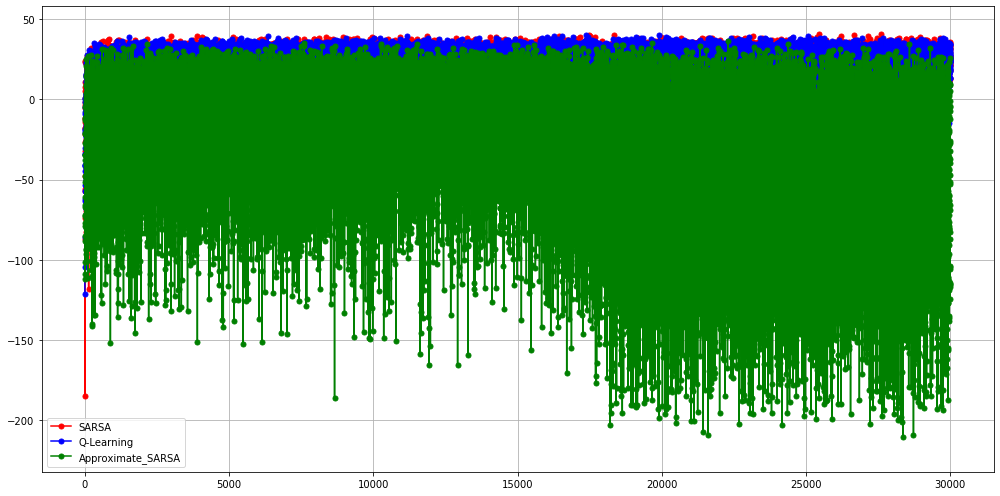

In [12]:
columns = [('SARSA', 'Q-Learning', 'Approximate_SARSA')]
colors = [('r', 'b', 'g')]
sizes = [(5, 5, 5)]
scale = [0.5]
figsize = (14, 7)

printing(df, columns, colors, sizes, scale, figsize = figsize, SAVE = None, SHOW = True)

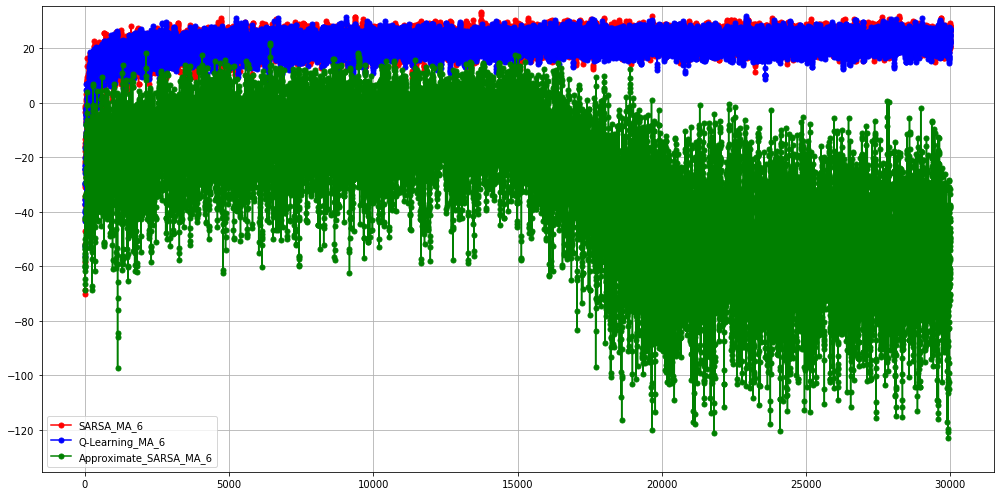

In [13]:
columns = [('SARSA_MA_6', 'Q-Learning_MA_6', 'Approximate_SARSA_MA_6')]
colors = [('r', 'b', 'g')]
sizes = [(5, 5, 5)]
scale = [0.5]
figsize = (14, 7)

printing(df, columns, colors, sizes, scale, figsize = figsize, SAVE = '{}_complicated_cost.png'.format(max_epoch), SHOW = True)